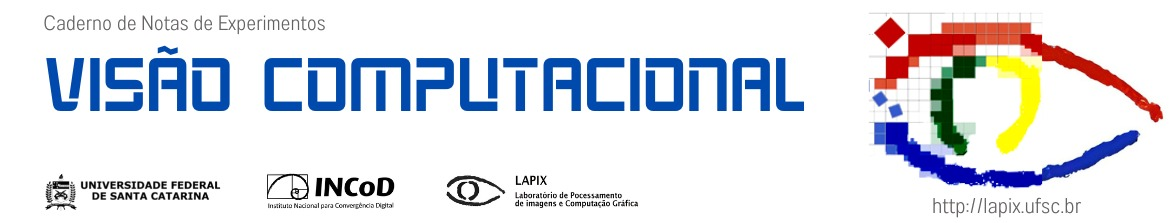

<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/17.1%20Transformers%20-%20Mecanismo%20de%20Aten%C3%A7%C3%A3o.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>

# 17.1. Transformers e o Mecanismo de Atenção

Nesse notebook, serão demonstrados duas redes tradicionais de transformers para área de visão: DETR  (End-to-End Object Detection with Transformers, Carion et al., 2020) e ViT (An image is worth 16x16 words, Dosovitskiy et al, 2020). DETR foi desenvolvido para tarefa de detecção de objetos, e ViT para classificação de imagens. As duas redes foram historicamente fundamentais para alavancar a tecnologia de transformers dentro da comunidade de visão computacional, mostrando que transformers oerformavam tão bem quanto às redes convolucionais (CNNs) para problemas de visão.


## Autores:


* Rafael de Souza Toledo: rafael.toledo@posgrad.ufsc.br
  * https://github.com/tldrafael
* Aldo von Wangenheim: aldo.vw@ufsc.br

<a href="https://youtu.be/yUQCvrI4xIo?si=7oK1GWKjtvBvpyau"><img align="left"  src="http://lapix.ufsc.br/wp-content/uploads/2023/11/YT60.png" alt="Assista no YouTube Aula 17.1. Transformers e o Mecanismo de Atenção" title="Assista no YouTube Aula 17.1. Transformers e o Mecanismo de Atenção"></a>

# Inicializações

## Para utilizar a placa de vídeo no Google Colab...

1) clique no ▾ do lado de "Conectar".

2) Ver recursos

3) Alterar o tipo de ambiente de execução

4) Acelerador de hardware: GPU

5) Execute a célula abaixo. Ela deve retornar as informações da placa de vídeo. Certifique-se de o seu Colab alocou pelo menos uma GPU Tesla T4. Se você só conseguiu alocar uma K80, desconecte e tente de novo, você terá dificuldades de realizar os experimentos descritos aqui com uma K80. SE você possui uma conta Google Pro, você deverá ter acesso a uma A100: não será necessária.

In [ ]:
!nvcc --version
!nvidia-smi
try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False
    %reload_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython import get_ipython
    
print('Running on Google Colab = ', _ON_COLAB)
import os
import torch

In [2]:
# !pip install einops timm
# !git clone https://github.com/EliSchwartz/imagenet-sample-images.git
# !wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [3]:
import torch
from torch import nn, einsum
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision import ops
from einops import rearrange, reduce
torch.set_grad_enabled(False)

import timm
from timm.models import vision_transformer
from functools import partial
from urllib.request import urlopen
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import iglob
from skimage import io
import math
import pandas as pd
import os


IN_names = pd.read_json('../data/imagenet_class_index.json').loc[1,:].values



# COCO classes
CLASSES = np.array([
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush', 'empty'
])

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100


def plot_im_with_boxes(im, boxes, probs=None):
    plt.imshow(im)
    ax = plt.gca()
    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b
        patch = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                              fill=False, color=COLORS[i], linewidth=3)
        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''
        ax.text(xmin, ymin, text, fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')

# DETR: Detection with Transformers

DETR realiza a tarefa de detecção de objeto, o que implica em inscrever um *box* entorno de um objeto e classificar a classe do mesmo. 


Inicialmante, a gente declara métodos para nos ajudarão a exemplificar o uso do DETR, o modelo do treinado do DETR é baixado diretamente do *hub* do pytorch.

In [ ]:

T_detr = T.Compose([
    T.ToTensor(),
    # T.Resize((800, 800)),
    T.Resize(800),
    # T.Resize(200),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


reverse_IN = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225])



detr = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
detr.eval();

Você pode tentar com múltiplas opções salva na pasta de exemplos da imagenet, mas como opção padrão, seguiremos com o exemplo do tucano.

../data/n01843383_toucan.JPEG
(375, 500, 3)


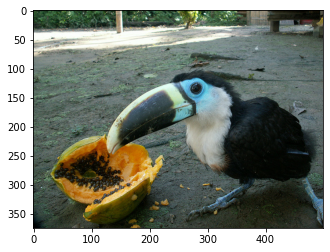

In [5]:

impaths = list(iglob('imagenet-sample-images/*'))
# p = np.random.choice(impaths,1)[0]
p = '../data/n01843383_toucan.JPEG'
print(p)


im = io.imread(p)
print(im.shape)
plt.imshow(im)
plt.show()

A fim de verificar mais adiante onde o modelo presta atenção no *feedforward pass* da rede, declaramos um *hook* na última camada do encoder do transformer. Hooks são funções do pytorch que podem ser posicionado em qualquer lugar da rede a fim de registrar valores dos tensores de entrada, saída, ou gradientes processados tanto durante o *feedforward pass* ou *backward pass*. 

Aqui, a última camada do encoder foi escolhida porque nas camadas mais funda da rede é onde processam-se informações mais pertinentes à semântica da imagem, isto é, o conteúdo da imagem, o que é mais útil para o nosso exemplo abaixo.

In [6]:
# use lists to store the outputs via up-values
hooks_out = []

cur_layer = detr.transformer.encoder.layers[-1].self_attn

hooks = [
    cur_layer.register_forward_hook(
        lambda self, input, output: hooks_out.append(output))
]

inp_detr = T_detr(im.copy())[None]
output = detr(inp_detr)

for hook in hooks:
    hook.remove()

Segue a resposta do modelo pre-treinado do DETR.

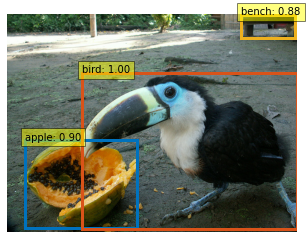

In [7]:
probs = output['pred_logits'].softmax(-1)[0]
keep = torch.bitwise_and(
    probs.argmax(-1) < 91, probs.amax(-1) > .8)

pred_boxes = output['pred_boxes'][0]

scale = im.shape[:2][::-1] * 2
scale = torch.tensor([scale])
pred_boxes = ops.box_convert(pred_boxes*scale, in_fmt='cxcywh', out_fmt='xyxy')


plot_im_with_boxes(im, pred_boxes[keep], probs[keep])

## O mecanismo de atenção e *attention scores*

O mecanismo de atenção funciona como um filtro, no qual para cada token são computados coeficientes de atenção entre ele e todos (os outros tokens e mais a si próprio). Os coeficientes de atenção possuem valores entre [0, 1], e para cada token a soma de seus coeficientes de atenção somam 1, similar a valores de probabilidade.

O coeficiente de atenção é análago ao peso $w_{i,j}$ entre dois neurônios $(i,j)$ da rede, mas diferentemente de uma rede convencional (FeedFoward Network - FFN), esse peso é computado pela multiplicação de queries ($Q$) e keys ($K$) e posteriormente normalizado pelo número de canais $d_k$ e pela função $softmax$, resultado na fórmula $softmax(\frac{QK^T}{\sqrt{d_k}})$.

Uma das propriedades do transformer é que cada token tem atenção global, isto é, ele é capaz de prestar atenção à informação de todos os outros tokens que formam a imagem, ao contrário de uma rede convolucional, onde a atenção é local e cada neurônio presta atenção só a seus vizinhos.

Tratando-se de imagem, um token é equivalente a um *patch* da imagem, isto é, no caso do DETR, uma pequena área de de 32x32 pixels. Cada patch é comprimido em único token. Por exemplo, a imagem do tucano após *resize* guardado na variável `inp_detr` tem dimensões (h=800,w=1066) o que resulta em um arranjo de (h=25, w=34) tokens, totalizando 577 tokens. No exemplo abaixo, mostramos onde os token assinalados mais prestam atenção. isto é, onde seus valores dos coeficientes de atenção são mais altos.

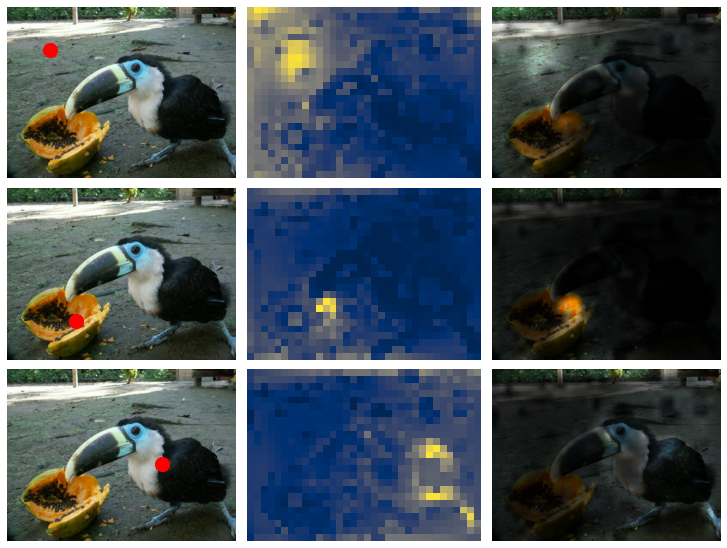

In [8]:


att_scores = hooks_out[0]
# o "hook" salva uma tupla: a saída em sida camada MHSA, e os attention scores computados
# aqui só nos endereça prosseguir com os attention scores
att_scores = att_scores[1][0]


point_list = [
    (200,200), (320,620), (720,440)
]


nrows = len(point_list)
fig, axs = plt.subplots(nrows, 3, figsize=(10, 2.5*nrows), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]

for i, (px, py) in enumerate(point_list):
    inp_H, inp_W = inp_detr.shape[2:]
    # Patch-size = 32
    sa_H = math.ceil(inp_H / 32)
    sa_W = math.ceil(inp_W / 32)

    px_sa = (px / inp_W) * sa_W
    py_sa = (py / inp_H) * sa_H
    px_sa = int(px_sa + .5)
    py_sa = int(py_sa + .5)

    p_sa = py_sa * sa_W + px_sa
    # Onde ele presta atenção
    sa_point = att_scores[p_sa, :].reshape(sa_H, sa_W)
    # Quem presta atenção nele
    # sa_point = att_scores[:, p_sa].reshape(sa_H, sa_W)

    inp_im = reverse_IN(inp_detr)[0].permute(1,2,0).numpy()
    sa_scores_gray = cv2.resize(sa_point.numpy(), (inp_W, inp_H))[...,None]
    blend = inp_im * sa_scores_gray * 1.5
    blend = blend * inp_im.max() / blend.max()

    axs[i, 0].imshow(inp_im)
    axs[i, 0].scatter(px, py, c='red', s=200)
    axs[i, 1].imshow(sa_point, cmap='cividis', interpolation='nearest')
    axs[i, 2].imshow(blend)

## Plota matriz de *attention scores* (Patches x Patches)

A gente pode expandir a ideia acima plotando uma matriz 577x577 tokens, onde cada linha é um token, e as colunas guardam seus coeficientes de atenção. A fim de representar essa matriz, a informação 2D de (h=25, w=34) tokens da imagem é enfileirada em uma única sequência 1D de 577 tokens.

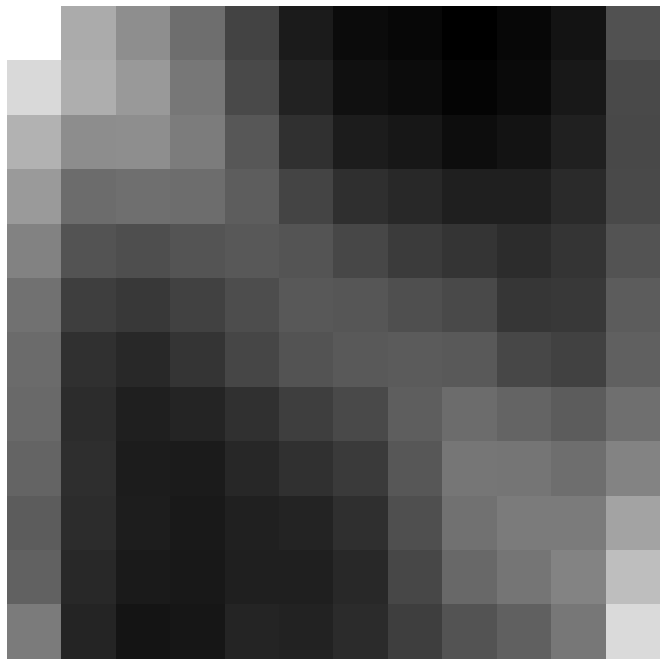

In [9]:
# Para melhor visualização, a quantidade de tokens foi compactada
inp_ = T.functional.resize(att_scores[:, :][None], (12, 12), interpolation=T.InterpolationMode.BILINEAR)[0]
# Use o input `att_scores` original para ver com o uso de todos os patches.
# inp_ = att_scores

plt.figure(figsize=(12,12))
plt.imshow(inp_, cmap='gray')
plt.axis('off');

***

# ViT: Vision Transformers

ViT realiza a tarefa de classificação de imagens, assinalando uma classe para a imagem inteira.

In [10]:
vit = timm.create_model('vit_base_patch16_clip_384.openai_ft_in1k', pretrained=True)
vit.eval();


T_vit = T.Compose([
    T.ToTensor(),
    T.Resize((384, 384), interpolation=T.InterpolationMode.BICUBIC, antialias=None),
    T.Normalize(
        mean=[0.481, 0.458, 0.408],
        std=[0.269, 0.261, 0.276])
])

../data/n01843383_toucan.JPEG
(375, 500, 3)


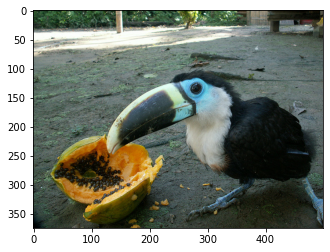

In [11]:

# impaths = list(iglob('imagenet-sample-images/*'))
# p = np.random.choice(impaths,1)[0]
p = '../data/n01843383_toucan.JPEG'
print(p)


im = io.imread(p)
print(im.shape)
plt.imshow(im)
plt.show()

Novamente, seguimos com o exemplo do tucano, que é corretamente classificado pela rede.

In [12]:
inp_ = T_vit(im)[None]
output = vit(inp_)[0]
probs = output.softmax(-1)


best_ixs = probs.argsort().flip(-1)[:5]
for ix in best_ixs:
    print(f'{IN_names[ix]}: {probs[ix]*100:.1f}%')


toucan: 91.4%
hornbill: 0.9%
macaw: 0.1%
magpie: 0.0%
chainlink_fence: 0.0%


Adicionamos um *hook* ao ViT para capturarmos os valores computados no passo frontal. Aqui a gente escolheu o bloco "3" arbitrariamente, você pode tentar outros blocks; ViT tem 12 blocos de encoder. Os blocos iniciais tem uma atenção mais local, enquanto os últimos, uma atenção mais global, pois a rede tende a computar mais informações geométricas nas primeiras camadas, e mais informações de conteúdo nas camadas finais. 

Diferentemente, do DETR que tem a tarefa de localização das caixas, a informação espacial no ViT acaba se esvaindo ao longo da profundidade da rede.

In [13]:
hooks_out = []

cur_layer = vit.blocks[-3].attn
num_heads = cur_layer.num_heads
head_dim = cur_layer.head_dim

hooks = [
    cur_layer.qkv.register_forward_hook(
        lambda self, input, output: hooks_out.append(output))
]


inp_vit = T_vit(im.copy())
output = vit(inp_vit[None])

for hook in hooks:
    hook.remove()

    
    
# Computa os coeficientes de atenção a partir da fóruma com queries e keys.
qkv = hooks_out[0]

print(qkv.shape)
# torch.Size([1, 577, 2304]) = (B, N, 3*C)
# B = batch size, N = n patches, C = feature dimensions

B, N, C = qkv.shape
qkv = qkv.reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)
q, k, v = qkv.unbind(0)

att_scores = q @ k.transpose(-2, -1)

# Atenua os logits para evitar valores muito assertivos de probabilidades, isto é, valores muito próximos a 0 ou 1.
scale = head_dim ** -.5
att_scores = att_scores * scale

# Computa probabilidades
att_scores = att_scores.softmax(dim=-1)

torch.Size([1, 577, 2304])


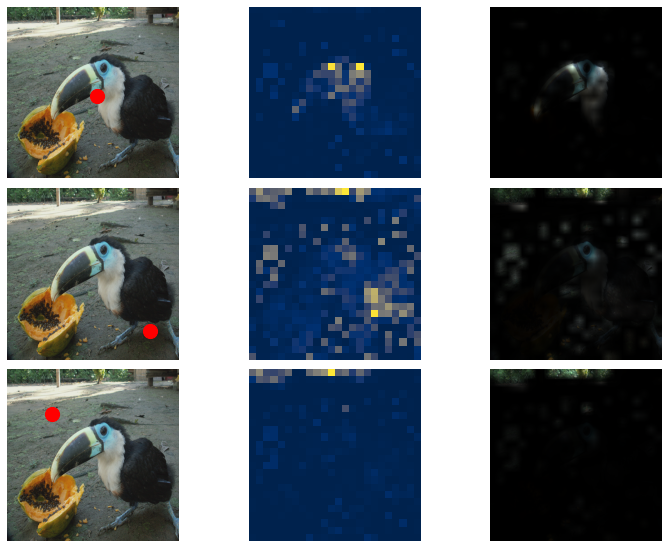

In [14]:

point_list = [
    (200,200), (320,320), (100,100)
]


nrows = len(point_list)
fig, axs = plt.subplots(nrows, 3, figsize=(10, 2.5*nrows), constrained_layout=True)
[a.set_axis_off() for a in axs.ravel()]


for i, (px, py) in enumerate(point_list):
    inp_H, inp_W = inp_vit.shape[1:]
    # Patch-size = 16
    sa_H = math.ceil(inp_H / 16)
    sa_W = math.ceil(inp_W / 16)

    px_sa = (px / inp_W) * sa_W
    py_sa = (py / inp_H) * sa_H
    px_sa = int(px_sa + .5)
    py_sa = int(py_sa + .5)

    # O primeiro token do att_scores é o token CLASS, que é pulado na matemática abaixo.
    p_sa = py_sa * sa_W + px_sa
    
    # Head é o índice do head escolhido pra visualização, 
    # pode ser qualquer valor entre 0 e 11.
    head = 10
    # Onde ele presta atenção
    sa_point = att_scores[0, head][1+p_sa, 1:].reshape(sa_H, sa_W)
    # Quem presta atenção nele
    # sa_point = att_scores[0, head][1+p_sa, 1:].reshape(sa_H, sa_W)

    inp_im = reverse_IN(inp_vit).permute(1,2,0).numpy().clip(0, 1)
    sa_scores_gray = cv2.resize(sa_point.numpy(), (inp_W, inp_H))[...,None]
    blend = inp_im * sa_scores_gray
    blend = blend * inp_im.max() / blend.max()

    axs[i, 0].imshow(inp_im)
    axs[i, 0].scatter(px, py, c='red', s=200)
    axs[i, 1].imshow(sa_point, cmap='cividis', interpolation='nearest')
    axs[i, 2].imshow(blend)

## Onde o token CLASS presta atenção

Uma das características do ViT é a adição de um token extra aos tokens oriundos dos patches da imagem, o token CLASS. 

Ao final do passo frontal da rede, após todas as camadas de transformer, todos os tokens são descartados, exceto o token CLASS, que será processado por uma FFN a fim de gerar as probabilidades da predição de cada classe.

In [15]:
def get_attention_map(impath, block=11):

    # Use lists to store the outputs via up-values
    hooks_out = []
    num_heads = vit.blocks[-1].attn.num_heads
    head_dim = vit.blocks[-1].attn.head_dim

    hooks = []
    hooks.append(
        vit.blocks[block].attn.qkv.register_forward_hook(
            lambda self, input, output: hooks_out.append(output))
    )

    im = cv2.imread(impath)[..., ::-1]
    inp_vit = T_vit(im.copy())
    
    output = vit(inp_vit[None])
    probs = output.softmax(-1)[0]

    for hook in hooks:
        hook.remove()

    qkv = hooks_out[0]
    
    B, T, C = qkv.shape
    qkv = qkv.reshape(B, T, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)
    
    # Compute attention-scores usando a fórmula mostrada antes
    att_scores = q @ k.transpose(-2, -1)
    scale = head_dim ** -.5
    att_scores = att_scores * scale
    att_scores = att_scores.softmax(dim=-1)


    return inp_vit, att_scores, probs

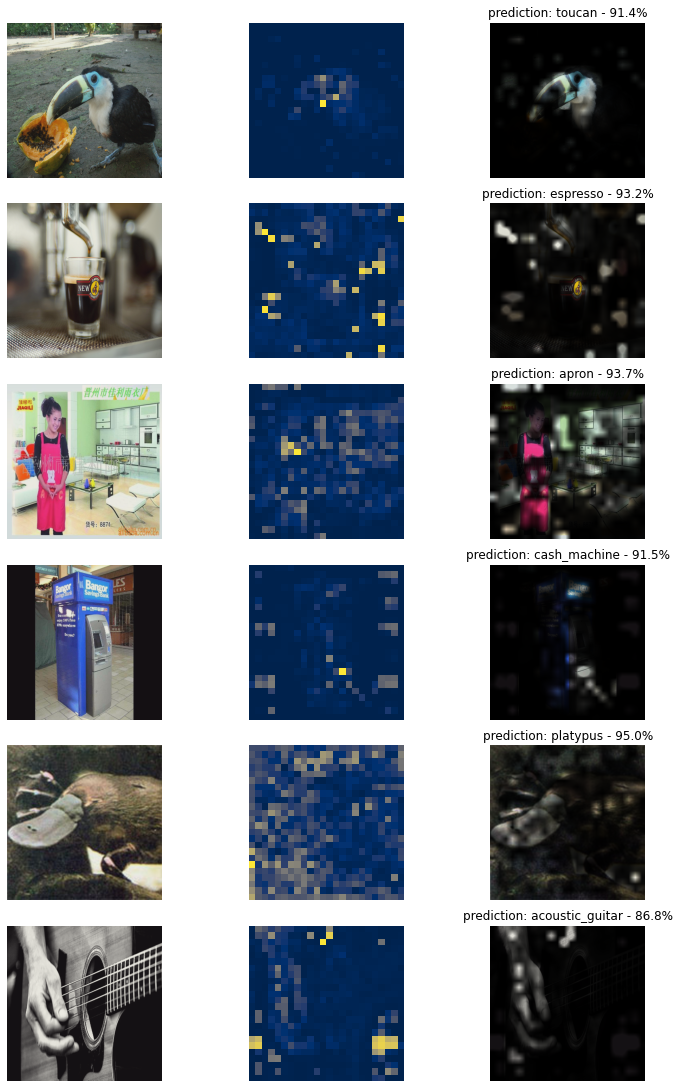

In [16]:

samples = ['../data/n01843383_toucan.JPEG']
# Não esqueça de baixar o repositório do imagenet-samples (checar git-clone do início do notebook)
if os.path.exists('imagenet-sample-images/'):
    impaths = list(iglob('imagenet-sample-images/*'))
    samples += np.random.choice(impaths, 5).tolist()


nrows = len(samples)
fig, axs = plt.subplots(
    nrows, 3, figsize=(10, 2.5*nrows), constrained_layout=True, squeeze=False)
[a.set_axis_off() for a in axs.ravel()]


for i, p in enumerate(samples):
    im = io.imread(p)
    # Selecione os blocos arbitrariamente entre 0 e 11.
    block = 11
    inp_vit, att_scores, probs = get_attention_map(p, block=block)

    pred_class = IN_names[probs.argmax()]
    pred_prob = probs.amax() * 100

    inp_H, inp_W = inp_vit.shape[1:]
    sa_H = math.ceil(inp_H / 16)
    sa_W = math.ceil(inp_W / 16)
    inp_im = reverse_IN(inp_vit).permute(1,2,0).numpy().clip(0, 1)

    head = 1
    ix_tokenCLASS = 0
    sa_point = att_scores[ix_tokenCLASS, head][0, 1:].reshape(sa_H, sa_W)
    sa_point = sa_point ** .8 # for better visualization

    sa_scores_gray = cv2.resize(sa_point.numpy(), (inp_W, inp_H))[..., None]
    sa_scores_gray = (sa_scores_gray - sa_scores_gray.min()) / (np.quantile(sa_scores_gray, .975) - sa_scores_gray.min())
    blend = inp_im * sa_scores_gray.clip(0, 1)

    axs[i, 0].imshow(inp_im)
    axs[i, 1].imshow(sa_point, cmap='cividis', interpolation='nearest')
    axs[i, 2].imshow(blend)
    axs[i, 2].set_title(f'prediction: {pred_class} - {pred_prob:.1f}%')

![banner cnns ppgcc ufsc](https://lapix.ufsc.br/wp-content/uploads/2022/10/rodape-CC.png)